In [5]:
import sys
import os
import bw2data as bd
import bw2calc as bc
import bw2io as bi
#from bw_temporalis import TemporalDistribution
sys.path.append(os.path.realpath('../'))
import numpy as np

In [6]:

PROJECT_NAME = "bw25_EV_setac"
RESET= False

if PROJECT_NAME in bd.projects and not RESET: # use existing project
    print("Using existing project: {}".format(PROJECT_NAME))
    bd.projects.set_current(PROJECT_NAME, writable=True) #not have readonly exchanges
    
else: # create project from scratch
    print("Creating new project: {}".format(PROJECT_NAME))
    if PROJECT_NAME in bd.projects:
        bd.projects.delete_project(PROJECT_NAME)
    bi.backup.restore_project_directory(r'filepath/to/backup/directory') # tar file shared on slack
    bd.projects.set_current(PROJECT_NAME)
    
bd.databases

Using existing project: bw25_EV_setac


Databases dictionary with 6 object(s):
	biosphere3
	cutoff39
	db_2020
	db_2030
	db_2040
	foreground

In [7]:
del bd.databases["foreground"]

In [8]:
# prospective databases were generated with premise, updating only electricity
db_2020 = bd.Database("db_2020")
db_2030 = bd.Database("db_2030")
db_2040 = bd.Database("db_2040")

In [9]:
#EV transport process 2020
EV_km_2020 = [x for x in db_2020 if (x['name'] == 'transport, passenger car, electric' )][0]


In [10]:
foreground = bd.Database('foreground')
foreground.register()

EV= foreground.new_node(
    code = "EV",
    name = "foreground transport, electric vehicle, 1km",
    location = "GLO",
)
EV.save()

EV.new_edge(input=("foreground", "EV"), amount=1.0, unit = "kilometer", type="production").save() #add production amount

#add technosphere exchanges
for exc in EV_km_2020.exchanges(): #looping over the exchanges of the EV process in the background db and adding them to our EV process in the foreground
    if not exc.input == exc.output and "market for passenger car, electric, without battery" not in exc.input["name"]: #skip production exchange of process and car production, which we"ll move to the foreground separately
        #add other exchanges of EV process
        EV.new_edge(input=exc.input.key, amount=exc['amount'], type=exc["type"]).save() #  

In [11]:
#add car production separately (we skip the ecoinvent GLO market for car production, as it only has 1 input of GLO car production, and no losses)
car_prod_background = [x for x in db_2020 if (x['name'] == 'passenger car production, electric, without battery')][0]

car_prod = foreground.new_node(
    code = "car_prod",
    name = "foreground car production, electric, without battery",
    location = "GLO",
)
car_prod.save()

car_prod.new_edge(input=("foreground", "car_prod"), amount=1.0, unit= "kilogram", type="production").save() #add production amount
#TODO undertsand why impact of production is different betweeen foreground system and background system
#add technosphere exchanges
for exc in car_prod_background.exchanges(): #looping over the exchanges of the EV process in the background db and adding them to our EV process in the foreground
    if not exc.input == exc.output: #skip production exchange
        #add other exchanges of car production
        car_prod.new_edge(input=exc.input.key, amount=exc['amount'], type=exc["type"]).save() #

 
for exc in EV_km_2020.exchanges():
    if "market for passenger car, electric, without battery" in exc.input["name"]:
        amount_car_prod_background= exc["amount"] #find amount of car production per 1 km EV driving in background db

EV.new_edge( #add new car prod to EV process
    input=("foreground", "car_prod"),
    amount=amount_car_prod_background,
    type="technosphere"
).save()



In [12]:
for exc in car_prod_background.biosphere():
    print(exc)

for exc in car_prod_background.production():
    print(exc)

Exchange: -6.116388703958364e-06 kilogram 'market for waste glass' (kilogram, CY, None) to 'passenger car production, electric, without battery' (kilogram, GLO, None)>
Exchange: -0.0010599906090646982 kilogram 'market for waste rubber, unspecified' (kilogram, CH, None) to 'passenger car production, electric, without battery' (kilogram, GLO, None)>
Exchange: -0.0029251330997794867 kilogram 'market for waste glass' (kilogram, BR, None) to 'passenger car production, electric, without battery' (kilogram, GLO, None)>
Exchange: -0.005556371994316578 kilogram 'market group for waste glass' (kilogram, RER, None) to 'passenger car production, electric, without battery' (kilogram, GLO, None)>
Exchange: -0.0009497396531514823 kilogram 'market for waste mineral oil' (kilogram, Europe without Switzerland, None) to 'passenger car production, electric, without battery' (kilogram, GLO, None)>
Exchange: 1.0 kilogram 'passenger car production, electric, without battery' (kilogram, GLO, None) to 'passeng

In [13]:
# checking if product system links correctly
for act in bd.Database('foreground'):
    print(act)
    for exc in act.exchanges():
        print(exc["amount"], exc.input["name"], exc.input["database"])
    print ("----------------")

'foreground car production, electric, without battery' (None, GLO, None)
1.0 foreground car production, electric, without battery foreground
-6.1163887e-06 market for waste glass db_2020
-0.0010599906 market for waste rubber, unspecified db_2020
-0.002925133 market for waste glass db_2020
-0.005556372 market group for waste glass db_2020
-0.00094973965 market for waste mineral oil db_2020
-0.025250005 market for waste rubber, unspecified db_2020
-2.5153588e-05 market for waste glass db_2020
-2.3511777e-05 market for waste mineral oil db_2020
-0.0024867486 market for waste mineral oil db_2020
-0.025250005 market for waste rubber, unspecified db_2020
-0.00011255306 market for waste glass db_2020
-3.8197126e-05 market for waste glass db_2020
-0.02756687 market for waste glass db_2020
-0.0002696032 market for waste glass db_2020
0.9126353 market for glider, passenger car db_2020
0.08736468 market for powertrain, for electric passenger car db_2020
1.0 market for manual dismantling of used e

In [14]:
CC_method = [m for m in bd.methods if 'IPCC 2021' in str(m) and  'climate change no LT' in str(m) and 'GWP100' in str(m) and 'no LT' in str(m)][0]
CC_method

('IPCC 2021 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

In [15]:
#compare EV in fore and background
demand = {EV_km_2020.key: 1}
method = CC_method

lca_bg = bc.LCA(demand, method)
lca_bg.lci()
lca_bg.lcia()
lca_bg.score

#check with foreground process:
demand = {('foreground', 'EV'): 1}
method = CC_method

lca_fg = bc.LCA(demand, method)
lca_fg.lci()
lca_fg.lcia()
lca_fg.score

print(f"1 km of EV driving: Foreground: {lca_fg.score} vs Background: {lca_bg.score}")

1 km of EV driving: Foreground: 0.22196471361962195 vs Background: 0.230222822980059


### below: understanding why scores are different but without success

In [16]:
#compare car prod in fore and background
demand = {car_prod_background.key: 1}
method = CC_method

lca_bg = bc.LCA(demand, method)
lca_bg.lci()
lca_bg.lcia()
lca_bg.score

demand = {('foreground', 'car_prod'): 1}
method = CC_method

lca_fg = bc.LCA(demand, method)
lca_fg.lci()
lca_fg.lcia()
lca_fg.score

print(f"1 kg of car production: Foreground: {lca_fg.score} vs Background: {lca_bg.score}")

1 kg of car production: Foreground: 7.143851026405615 vs Background: 7.484964738948721


In [17]:
#check all material sums and process numbers -> no biosphere flows!
sum_amount_foreground=0
num_proc_foreground=0
num_tech_fg=0
num_bio_fg=0
num_bio_fg=0
num_prod_fg=0

sum_amount_background=0
num_proc_background=0
num_tech_bg=0
num_bio_bg=0
num_prod_bg=0

for exc in car_prod.exchanges():
    #print(exc["amount"], exc["type"], exc.input["name"], exc.input["location"], exc.input["database"] , sep="\t")
    sum_amount_foreground+=exc["amount"]
    num_proc_foreground+=1
    if exc["type"]=="technosphere":
        num_tech_fg+=1
    if exc["type"]=="biosphere":
        num_bio_fg+=1
    if exc["type"]=="production":
        num_prod_fg+=1
        

for exc in car_prod_background.exchanges():
    #print(exc["amount"], exc["type"], exc.input["name"], exc.input["location"],  sep="\t")
    sum_amount_background+=exc["amount"]
    num_proc_background+=1
    if exc["type"]=="technosphere":
        num_tech_bg+=1
    if exc["type"]=="biosphere":
        num_bio_bg+=1
    if exc["type"]=="production":
        num_prod_bg+=1

print(f"\nsum material amount: fg: {sum_amount_foreground}, bg: {sum_amount_background}. \nnumber of processes: fg: {num_proc_foreground}, bg: {num_proc_background}")
print(f"number of tech exc: fg: {num_tech_fg}, bg: {num_tech_bg}. \nnumber of bio exc: fg: {num_bio_fg}, bg: {num_bio_bg} \nnumber of prod exc: fg: {num_prod_fg}, bg: {num_prod_bg}")
print(f"lca score: fg: {lca_fg.score} vs bg: {lca_bg.score}")



sum material amount: fg: 2.908480008461538, bg: 2.908480008461538. 
number of processes: fg: 18, bg: 18
number of tech exc: fg: 3, bg: 3. 
number of bio exc: fg: 0, bg: 0 
number of prod exc: fg: 15, bg: 15
lca score: fg: 7.143851026405615 vs bg: 7.484964738948721


In [18]:
# fg reference flow
prod_exc = [exc for exc in car_prod.exchanges() if exc.input["name"] == exc.output["name"]][0]
prod_exc.__dict__

{'_document': <ExchangeDataset: 676302>,
 '_data': {'output': ('foreground', 'car_prod'),
  'input': ('foreground', 'car_prod'),
  'amount': 1.0,
  'unit': 'kilogram',
  'type': 'production'},
 '_input': 'foreground car production, electric, without battery' (None, GLO, None),
 '_output': 'foreground car production, electric, without battery' (None, GLO, None)}

In [41]:
prod_exc_bg = [ exc for exc in car_prod_background.exchanges() if exc.input["name"] == exc.output["name"]][0]
prod_exc_bg.__dict__

{'input': 'passenger car production, electric, without battery' (kilogram, GLO, None),
 'output': 'passenger car production, electric, without battery' (kilogram, GLO, None),
 'amount': 1.0,
 '_data': {'amount': 1.0,
  'uncertainty_type': 0,
  'type': 'production',
  'input': ('db_2020', '2faf7f39dced7d6bad666f90033d76f9'),
  'output': ('db_2020', '2faf7f39dced7d6bad666f90033d76f9')}}

In [21]:
#compare LCA results by sub-process
import pandas as pd

def do_lca(process, method):
    demand = {process.input.key: process.amount}
    lca = bc.LCA(demand, method)
    lca.lci()
    lca.lcia()
    return lca.score
calc_count_fg=0
calc_count_bg=0
results_df = pd.DataFrame() #columns=["exchange", "database1", "database2"])
dict_results_1 = []
dict_results_2 = []

# Loop over input data and perform calculations for each input
for exc in car_prod.exchanges():
    result= do_lca(exc, CC_method)
    dict_results_1.append({(exc.input["name"], exc.input["location"]):result})
    calc_count_fg+=1

# Loop over input data and perform calculations for each input
for exc in car_prod_background.exchanges():
    result= do_lca(exc, CC_method)
    dict_results_2.append({(exc.input["name"], exc.input["location"]):result})
    calc_count_bg+=1


In [22]:
# Convert data into DataFrame
flat_data = []
for d in dict_results_1:
    for key, value in d.items():
        flat_data.append({'input_name': key, 'Value': value})
df1 = pd.DataFrame(flat_data)

flat_data = []
for d in dict_results_2:
    for key, value in d.items():
        flat_data.append({'input_name': key, 'Value': value})
df2 = pd.DataFrame(flat_data)

results_df = pd.merge(df1, df2, on="input_name", how ="outer")
results_df["delta"]= results_df["Value_x"]-results_df["Value_y"]
results_df["difference_to_total_score [%]"]= results_df["Value_x"]/lca_bg.score*100 

In [24]:
results_df

,input_name,Value_x,Value_y,delta,difference_to_total_score [%]
0,"(foreground car production, electric, without ...",7.143851e+00,NaN,NaN,9.544268e+01
1,"(market for waste glass, CY)",6.531931e-08,6.531931e-08,0.0,8.726736e-07
2,"(market for waste rubber, unspecified, CH)",3.341704e-03,3.341704e-03,0.0,4.464556e-02
3,"(market for waste glass, BR)",5.626422e-05,5.626422e-05,0.0,7.516965e-04
4,"(market group for waste glass, RER)",1.557024e-04,1.557024e-04,0.0,2.080203e-03
5,"(market for waste mineral oil, Europe without ...",2.153274e-03,2.153274e-03,0.0,2.876799e-02
6,"(market for waste rubber, unspecified, RoW)",7.980411e-02,7.980411e-02,0.0,1.066192e+00
7,"(market for waste glass, IN)",1.734418e-06,1.734418e-06,0.0,2.317203e-05
8,"(market for waste mineral oil, CH)",5.851374e-05,5.851374e-05,0.0,7.817504e-04
9,"(market for waste mineral oil, RoW)",4.477542e-03,4.477542e-03,0.0,5.982048e-02


In [22]:
import bw2analyzer as ba
ca = ba.contribution.ContributionAnalysis()
ca.annotated_top_processes(lca_bg, limit=10)
ca.annotated_top_emissions(lca_fg, limit=10)

[(0.582722315238863,
  0.6862984610311513,
  'pig iron production' (kilogram, RoW, None)),
 (0.39136399843034175,
  0.16138296211097597,
  'treatment of residue from shredder fraction from manual dismantling, municipal waste incineration' (kilogram, RoW, None)),
 (0.34966611289893446,
  0.8639858766304461,
  'hard coal mine operation and hard coal preparation' (kilogram, CN, None)),
 (0.23562816678547388,
  2.0473454844472845,
  'heat production, at hard coal industrial furnace 1-10MW' (megajoule, RoW, None)),
 (0.1782925954652096,
  0.720613351369965,
  'iron sinter production' (kilogram, RoW, None)),
 (0.13897828872144707,
  0.007965741810447312,
  'natural gas venting from petroleum/natural gas production' (cubic meter, GLO, None)),
 (0.13820982148150324,
  0.1362904012441366,
  'electricity production, hard coal' (kilowatt hour, CN-SD, None)),
 (0.12564898431463734,
  0.12389378191821376,
  'electricity production, hard coal' (kilowatt hour, CN-NM, None)),
 (0.1141735522237947,
  0

In [43]:
ca.d3_treemap(lca_bg.technosphere_matrix, lca_bg.dicts.biosphere, lca_bg.dicts.activity.reversed, limit=0.025, limit_type='percent')

KeyError: 9848.0

In [54]:
def print_recursive_calculation(activity, lcia_method, lca_obj=None, total_score=None, amount=1, level=0, max_level=3, cutoff=1e-2):
    if lca_obj is None:
        lca_obj = bc.LCA({activity.key: amount}, lcia_method)
        lca_obj.lci()
        lca_obj.lcia()
        total_score = lca_obj.score
    elif total_score is None:
        raise ValueError
    else:
        lca_obj.redo_lcia({activity.id: amount})
        if abs(lca_obj.score) <= abs(total_score * cutoff):
            return
    print("{}{:4.3f} ({:06.4f}): {:.70}".format("  " * level, lca_obj.score / total_score, lca_obj.score, str(activity)))
    if level < max_level:
        for exc in activity.technosphere():
            print_recursive_calculation(
                activity=exc.input, 
                lcia_method=lcia_method, 
                lca_obj=lca_obj, 
                total_score=total_score, 
                amount=amount * exc['amount'], 
                level=level + 1, 
                max_level=max_level, 
                cutoff=cutoff
            )  

In [30]:
#using comparison function of bw2analyser
activities = [car_prod, car_prod_background]
ba.comparisons.compare_activities_by_lcia_score(activities, CC_method, band=0.01)

Differences observed. LCA scores:
	7.144 -> ('foreground', 'car_prod')
	7.485 -> ('db_2020', '2faf7f39dced7d6bad666f90033d76f9')


Contribution analysis is identical by contributing process, but the total amount is wrong!

In [65]:
print_recursive_calculation(car_prod_background, CC_method, lca_obj=None, total_score=None, amount=1, level=-1, max_level=2, cutoff=1e-4)

1.000 (7.4850): 'passenger car production, electric, without battery' (kilogram, GLO, 
0.767 (5.7421): 'market for glider, passenger car' (kilogram, GLO, None)
  0.767 (5.7421): 'glider production, passenger car' (kilogram, GLO, None)
    0.003 (0.0213): 'market for nylon 6' (kilogram, RoW, None)
    0.003 (0.0214): 'market for magnesium' (kilogram, GLO, None)
    0.011 (0.0823): 'market group for heat, district or industrial, natural gas' (megajoul
    0.018 (0.1324): 'market for polypropylene, granulate' (kilogram, GLO, None)
    0.000 (0.0032): 'market for sheet rolling, aluminium' (kilogram, GLO, None)
    0.009 (0.0650): 'market for fibre, viscose' (kilogram, GLO, None)
    0.001 (0.0041): 'market for zinc' (kilogram, GLO, None)
    0.009 (0.0648): 'market for road vehicle factory' (unit, GLO, None)
    0.002 (0.0168): 'market for aluminium, wrought alloy' (kilogram, GLO, None)
    0.000 (0.0009): 'market for lubricating oil' (kilogram, RER, None)
    0.000 (0.0023): 'market group

In [66]:
print_recursive_calculation(car_prod, CC_method, lca_obj=None, total_score=None, amount=1, level=-1, max_level=2, cutoff=1e-4)

1.000 (7.1439): 'foreground car production, electric, without battery' (None, GLO, Non
0.804 (5.7421): 'market for glider, passenger car' (kilogram, GLO, None)
  0.804 (5.7421): 'glider production, passenger car' (kilogram, GLO, None)
    0.003 (0.0213): 'market for nylon 6' (kilogram, RoW, None)
    0.003 (0.0214): 'market for magnesium' (kilogram, GLO, None)
    0.012 (0.0823): 'market group for heat, district or industrial, natural gas' (megajoul
    0.019 (0.1324): 'market for polypropylene, granulate' (kilogram, GLO, None)
    0.000 (0.0032): 'market for sheet rolling, aluminium' (kilogram, GLO, None)
    0.009 (0.0650): 'market for fibre, viscose' (kilogram, GLO, None)
    0.001 (0.0041): 'market for zinc' (kilogram, GLO, None)
    0.009 (0.0648): 'market for road vehicle factory' (unit, GLO, None)
    0.002 (0.0168): 'market for aluminium, wrought alloy' (kilogram, GLO, None)
    0.000 (0.0009): 'market for lubricating oil' (kilogram, RER, None)
    0.000 (0.0023): 'market group

In [34]:
ba.comparisons.compare_activities_by_grouped_leaves(activities, CC_method, mode='absolute', max_level=4, cutoff=0.0075, output_format='pandas', str_length=30)

,activity,product,location,unit,total,direct emissions,"4124: Bars and rods, hot-rolled, of iron or steel",None,4613: Parts for the goods of classes 4611 and 4612,"4611: Electric motors, generators and the like",...,6512: Railway transport services of freight,88531: Glass manufacturing services,33380: Lubricants,"41442: Zinc, unwrought","41441: Lead, unwrought",41513: Wire of copper,65219: Other coastal and transoceanic water transport services of other freight,18000: Natural water,36990: Articles of plastics n.e.c.,65229: Other inland water transport services of freight
0,"passenger car production, electric, without ba...","passenger car, electric, without battery",GLO,kilogram,7.484965,0.0,1.537191,1.271628,0.638605,0.519714,...,0.008767,0.006488,0.005689,0.004075,0.003663,0.002646,0.002294,0.002294,0.001852,0.000752
1,"foreground car production, electric, without b...",,GLO,,7.143851,0.0,1.537191,1.271628,0.638605,0.519714,...,0.008767,0.006488,0.005689,0.004075,0.003663,0.002646,0.002294,0.002294,0.001852,0.000752


In [35]:
import bw2analyzer as ba
ca = ba.contribution.ContributionAnalysis()
#ca.annotated_top_processes(lca_fg, limit=10)
ca.annotated_top_emissions(lca_fg, limit=10)

[(3.4869516299398082,
  3.4869516299398096,
  'Carbon dioxide, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks'))),
 (1.447295978089624,
  1.4472959780896237,
  'Carbon dioxide, fossil' (kilogram, None, ('air',))),
 (1.3662745854271725,
  1.3662745854271743,
  'Carbon dioxide, fossil' (kilogram, None, ('air', 'urban air close to ground'))),
 (0.6165726720393878,
  0.020690358651841594,
  'Methane, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks'))),
 (0.08835908794612665,
  0.002965070141217974,
  'Methane, fossil' (kilogram, None, ('air', 'urban air close to ground'))),
 (0.04108046084795087,
  0.00015047787856392248,
  'Dinitrogen monoxide' (kilogram, None, ('air', 'urban air close to ground'))),
 (0.01922163172619143,
  2.604557144470384e-06,
  'Methane, tetrafluoro-, R-14' (kilogram, None, ('air',))),
 (0.016559933486495714,
  6.06590970201308e-05,
  'Dinitrogen monoxide' (kilogram, None, ('air', 'non-urban air or from high stacks'))),
 (0.01

In [134]:
import bw2analyzer as ba
ca = ba.contribution.ContributionAnalysis()

ca.annotated_top_emissions(lca_bg, limit=10)

[(3.48945288809704,
  3.4894528880970355,
  'Carbon dioxide, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks'))),
 (1.7012817015789625,
  1.7012817015789647,
  'Carbon dioxide, fossil' (kilogram, None, ('air', 'urban air close to ground'))),
 (1.4494585621482359,
  1.4494585621482359,
  'Carbon dioxide, fossil' (kilogram, None, ('air',))),
 (0.617013415943002,
  0.02070514871609991,
  'Methane, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks'))),
 (0.08869706816567792,
  0.002976411759614088,
  'Methane, fossil' (kilogram, None, ('air', 'urban air close to ground'))),
 (0.04124832897220351,
  0.00015109278011796127,
  'Dinitrogen monoxide' (kilogram, None, ('air', 'urban air close to ground'))),
 (0.019222249090697037,
  2.6046407981974302e-06,
  'Methane, tetrafluoro-, R-14' (kilogram, None, ('air',))),
 (0.016566944870258216,
  6.068477974453564e-05,
  'Dinitrogen monoxide' (kilogram, None, ('air', 'non-urban air or from high stacks'))),
 (0.01

In [68]:
top_emissions_bg = ca.annotated_top_emissions(lca_bg, limit=10)

In [149]:
import pandas as pd
# Extracting data into separate lists
top_emissions_bg = ca.annotated_top_emissions(lca_bg, limit=10)
#column1 = [(item[2]["name"], item[2]["categories"]) for item in top_emissions_bg]
column2 = [(item[1]) for item in top_emissions_bg]
column3= [(item[2]["id"]) for item in top_emissions_bg]
df_bg = pd.DataFrame({'flow_id': column3, 'amount': column2,})# "id": column3})

top_emissions_fg = ca.annotated_top_emissions(lca_fg, limit=10)
#column1 = [(item[2]["name"], item[2]["categories"]) for item in top_emissions_fg]
column2 = [(item[1]) for item in top_emissions_fg]
column3= [(item[2]["id"]) for item in top_emissions_bg]
df_fg = pd.DataFrame({'flow_id': column3, 'amount': column2,})# "id": column3})

emission_comparison = pd.merge(df_fg, df_bg, on="flow_id", how ="outer")
emission_comparison["delta"]= emission_comparison["amount_x"]-emission_comparison["amount_y"]



In [150]:
emission_comparison 

,flow_id,amount_x,amount_y,delta
0,1168,3.486952,3.489453,-2.501258e-03
1,112,1.447296,1.701282,-2.539857e-01
2,1171,1.366275,1.449459,-8.318398e-02
3,1649,0.020690,0.020705,-1.479006e-05
4,438,0.002965,0.002976,-1.134162e-05
5,4684,0.000150,0.000151,-6.149016e-07
6,1664,0.000003,0.000003,-8.365373e-11
7,4685,0.000061,0.000061,-2.568272e-08
8,255,0.000001,0.000001,-7.957934e-12
9,3642,0.011209,0.011214,-5.623460e-06


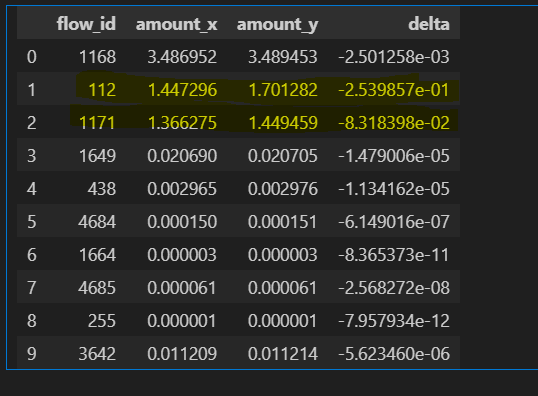
the problem lies here at biosphere flow 112 and 1171, but I don't know how to find the actual error

In [132]:
bd.get_node(id=112)

'Carbon dioxide, fossil' (kilogram, None, ('air', 'urban air close to ground'))

In [133]:
bd.get_node(id=1171)

'Carbon dioxide, fossil' (kilogram, None, ('air',))

In [165]:
co2_urban_air_id = lca_fg.dicts.biosphere.reversed[112]
co2_urban_air_id

156

check matrices

In [27]:
lca_fg.inventory

<2429x24107 sparse matrix of type '<class 'numpy.float64'>'
	with 302034 stored elements in Compressed Sparse Row format>

In [28]:
lca_bg.inventory

<2429x24105 sparse matrix of type '<class 'numpy.float64'>'
	with 302580 stored elements in Compressed Sparse Row format>

In [ ]:
lca_fg.demand

{98281: 1}

In [30]:
bd.get_node(id=29952)

'passenger car production, electric, without battery' (kilogram, GLO, None)

In [31]:
lca_fg.dicts.activity[98281] #matrix_id

24106

In [32]:
#retrieve exchanges directly from matrices -> also fine
column_ids = lca_fg.technosphere_matrix[:,24106].nonzero()

for id in column_ids[0]:
    lca_fg.technosphere_matrix[id,24106]
    print(lca_fg.technosphere_matrix[id,24106], bd.get_node(id=lca_fg.dicts.activity.reversed[id]))

-6.116388703958364e-06 'market for waste glass' (kilogram, CY, None)
-0.0010599906090646982 'market for waste rubber, unspecified' (kilogram, CH, None)
-0.912635326385498 'market for glider, passenger car' (kilogram, GLO, None)
-0.0029251330997794867 'market for waste glass' (kilogram, BR, None)
-0.005556371994316578 'market group for waste glass' (kilogram, RER, None)
-0.0009497396531514823 'market for waste mineral oil' (kilogram, Europe without Switzerland, None)
-0.02525000460445881 'market for waste rubber, unspecified' (kilogram, RoW, None)
-2.5153587557724677e-05 'market for waste glass' (kilogram, IN, None)
-2.3511776817031205e-05 'market for waste mineral oil' (kilogram, CH, None)
-0.002486748620867729 'market for waste mineral oil' (kilogram, RoW, None)
-0.02525000460445881 'market for waste rubber, unspecified' (kilogram, Europe without Switzerland, None)
-0.0001125530616263859 'market for waste glass' (kilogram, ZA, None)
-3.8197125832084566e-05 'market for waste glass' (ki